In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
import string

from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional, GRU
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_curve

import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented-all.csv

--2022-05-09 08:25:59--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5060506 (4.8M) [text/plain]
Saving to: ‘dev.csv’

dev.csv             100%[===================>]   4.83M  --.-KB/s    in 0.04s   

2022-05-09 08:25:59 (115 MB/s) - ‘dev.csv’ saved [5060506/5060506]

--2022-05-09 08:25:59--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40062185 (38M) [text/plain]
Saving 

In [4]:
# Download
embedding_dim = 50
glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dim}') # 50, 100, 200 or 300

[==================================================] 100.0% 66.0/66.0MB downloaded


#
# Data exploration

In [5]:
df = pd.read_csv("train.csv")
df = df.drop(["Unnamed: 0"],axis=1)

# df_aug = pd.read_csv("augmented.csv", sep='\t')
df_aug = pd.read_csv("augmented-all.csv", sep='\t')
df_aug['fraudulent'] = np.ones(len(df_aug), dtype=int)

df_val = pd.read_csv("dev.csv")
df_val = df_val.drop(["Unnamed: 0"],axis=1)

for df_column in df.columns:
    if df_column not in df_aug.columns:
        print("Dropped:", df_column)
        df = df.drop([df_column],axis=1)
        df_val = df_val.drop([df_column],axis=1)

df.head()

Dropped: job_id
Dropped: company_profile


,title,location,department,salary_range,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Maintenance Mechanic,"US, NY, Niagara Falls",Maintenance,NaN,DEPARTMENT: MaintenanceREPORTS TO: ...,NaN,NaN,0,1,0,Full-time,Mid-Senior level,NaN,Chemicals,Manufacturing,0
1,LS17 6DJ Customer Service Apprenticeship Avail...,"GB, , Leeds",NaN,NaN,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future prospects,0,1,1,NaN,NaN,NaN,NaN,NaN,0
2,Technical Support Representative,"US, OH, Westerville",NaN,NaN,A Customer Support Representative at Status So...,"TasksMonitor the Network Operations Center, ca...",Starting salary based on experience and educat...,0,1,1,Full-time,Not Applicable,Unspecified,Computer Software,Customer Service,0
3,Ruby on Rails Specialist,"US, CA, Long Beach",NaN,NaN,Ruby on Rails Web Engineer (RoR)Now Hiring Rub...,NaN,NaN,0,0,0,Full-time,Mid-Senior level,NaN,Information Technology and Services,NaN,0
4,Caregiver - Bridgman,"US, MI, Bridgman",NaN,NaN,Home Sweet Home In-Home Care is one of the fas...,NaN,Competitive compensation with performance revi...,0,1,1,NaN,NaN,High School or equivalent,Hospital & Health Care,Health Care Provider,0


#### Missing values

In [6]:
df_fake = df.loc[df["fraudulent"]==1]
df_true = df.loc[df["fraudulent"]==0]
df_fake

,title,location,department,salary_range,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
52,Client Audit Coordinator,"US, TX, Austin",COMPLIANCE UNIT 701,26000-30000,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,We offer a competitive and comprehensive range...,0,1,1,Full-time,Associate,High School or equivalent,Financial Services,Customer Service,1
75,Client Services Manager - SM1,"US, CA, San Mateo",Client Services,NaN,"Client Services Manager - SM1San Mateo, CA#URL...",Basic Qualifications:Proven experience in mana...,Our core values drive our culture. This is wha...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Marketing and Advertising,Information Technology,1
77,Receptionist,"GB, ,",NaN,NaN,We the Montcalm Hotel are looking for the posi...,Good Requirement,Package: Basic salary ranges from GBP2500 - 60...,0,0,0,Full-time,Entry level,NaN,Hospitality,NaN,1
84,CAD Operator,"US, TX, Houston",Engineering,NaN,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes Educa...,We offer• Friendly colleagues in an industry w...,0,0,0,NaN,NaN,NaN,Construction,Design,1
96,Position Admin Assistant,"AU, NSW, Sydney",NaN,22000-28000,We require an experienced Admin Assistant with...,• Excellent time management &amp; superb prese...,Part Time – 15 to 20 hours per week – you choo...,0,0,1,Part-time,Internship,Unspecified,Executive Office,Administrative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14204,"Agency Sales Managers $150-$175,000/yr","US, NY, Elmira",NaN,NaN,We provide No Credit Check Financing to custom...,Experience and Skills Required- Minimum of 3 ...,We Provide- Complete online training and offic...,0,1,0,Full-time,NaN,High School or equivalent,Financial Services,Sales,1
14228,Director of Engineering: Applications,"US, ,",Engineering,NaN,Director of...,What you bring to the table:BS / MS in compute...,"What We Offer: Competitive salary, excellent b...",0,1,1,Full-time,Director,Master's Degree,Ranching,Engineering,1
14253,Senior System Test Engineer,"US, CA, San Jose",Engineering,NaN,"Senior System Test Engineer | San Jose, CAAs a...",Skills and RequirementsBS in Computer Science ...,"Broad responsibility, autonomy and visibility ...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Networking,Engineering,1
14254,Adminstrative/Data Entry,"US, IL, Chicago",NaN,63000-63000,We are a network of national standards bodies....,"No requirements, Apply if you are in the force...","The job includes benefits such as health, dent...",0,0,0,Full-time,Entry level,Unspecified,Human Resources,Human Resources,1


In [7]:
def getNaNRatio(df):
    rows = len(df)
    for column in df.columns:
        print(f"{column}: {df[column].isna().sum()/rows}")

In [8]:
getNaNRatio(df_fake)

title: 0.0
location: 0.01925722145804677
department: 0.6107290233837689
salary_range: 0.7359009628610729
description: 0.001375515818431912
requirements: 0.16506189821182943
benefits: 0.40440165061898214
telecommuting: 0.0
has_company_logo: 0.0
has_questions: 0.0
employment_type: 0.28060522696011003
required_experience: 0.49105914718019256
required_education: 0.515818431911967
industry: 0.3177441540577717
function: 0.38514442916093533
fraudulent: 0.0


In [9]:
getNaNRatio(df_true)

title: 0.0
location: 0.01922368711792001
department: 0.6455770788834058
salary_range: 0.8439272298740517
description: 0.0
requirements: 0.15150622376077189
benefits: 0.4015614642409958
telecommuting: 0.0
has_company_logo: 0.0
has_questions: 0.0
employment_type: 0.19179494733740884
required_experience: 0.3928702953524343
required_education: 0.45223539809972746
industry: 0.2739191279369522
function: 0.36083081682256757
fraudulent: 0.0


#### Correlation (features with binary value)

In [10]:
# Correlation
df[["telecommuting","fraudulent"]].corr()

,telecommuting,fraudulent
telecommuting,1.00000,0.03296
fraudulent,0.03296,1.00000


In [11]:
df[["has_company_logo","fraudulent"]].corr()

,has_company_logo,fraudulent
has_company_logo,1.000000,-0.264599
fraudulent,-0.264599,1.000000


-0.26 is significant correlation for keeping this feature

In [12]:
df[["has_questions","fraudulent"]].corr()

,has_questions,fraudulent
has_questions,1.000000,-0.092613
fraudulent,-0.092613,1.000000


# Preprocessing

## Fill nan

In [13]:
df = df.fillna("none")
df_aug = df_aug.fillna("none")
df_val = df_val.fillna("none")

## Concatenate Train and Augmented datasets

In [14]:
print('Train dataset length:', len(df))
print('Augmented dataset length:', len(df_aug))

df = pd.concat([df_aug, df])
df = df.reset_index()

print('Train dataset after concatenation:', len(df))

Train dataset length: 14304
Augmented dataset length: 14530
Train dataset after concatenation: 28834


## Merged features embeddings

In [15]:
def merge(df):
    # df = df.assign(merged_features=lambda df: df["title"]+" "+df["location"]+" "+df["department"]+
    #           df["employment_type"]+" "+df["required_experience"]+" "+df["required_education"]+" "+
    #            df["industry"]+" "+df["function"])
    
    # df = df.assign(merged_features=lambda df: df["description"])
    
    df = df.assign(merged_features=lambda df: 
                   df["title"]+" "
                   +df["location"]+" "
                   +df["department"]
                  #  +df["employment_type"]+" "
                  #  +df["required_experience"]+" "
                  #  +df["required_education"]+" "
                  #  +df["industry"]+" "
                  #  +df["function"]+" "
                   +df["description"]+" "
                  #  +df["requirements"]+" "
                  #  +df["benefits"]
                   )
    

    return df[["merged_features","fraudulent"]]

In [16]:
df_merged = merge(df)
df_val_merged = merge(df_val)
df_merged.head()

,merged_features,fraudulent
0,"Client Audit coordinator Coordinator us, tx, a...",1
1,"national audit coordinator us, ny, ny complian...",1
2,"node audit coordinator Austin TX, US, 701 UNIT...",1
3,"client Audit Coordinator US, TX, capital of te...",1
4,"Client scrutinize Coordinator US, TX, Austin C...",1


In [17]:
# Lowercase, removing stop words, punctuation, numbers, stemming

# Input -> array of docs
def preprocess_texts(texts):
    preprocessed = []
    stop_words = stopwords.words('english')
    punct=string.punctuation
    # stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    print("Preprocessing..")
    for text in tqdm(texts):
        words = word_tokenize(text)
        words = [''.join([i for i in word if not i.isdigit()]) for word in words] # Removing numbers
        # All in one :)
        words = [lemmatizer.lemmatize(word.lower()) for word in words if (word not in stop_words) and (word not in punct)]
        preprocessed.append(words)
        
    print("Done")
    return preprocessed
        

In [18]:
features_train = np.array(df_merged["merged_features"])
target_train = np.array(df_merged["fraudulent"])

features_val = np.array(df_val_merged["merged_features"])
target_val = np.array(df_val_merged["fraudulent"])

In [19]:
preprocessed_train = preprocess_texts(features_train)
preprocessed_val = preprocess_texts(features_val)
#print(preprocessed[:3])

Preprocessing..


100%|██████████| 28834/28834 [01:12<00:00, 399.35it/s]


Done
Preprocessing..


100%|██████████| 1788/1788 [00:04<00:00, 397.88it/s]

Done


#### GloVe

In [20]:
def texts2embeddings(texts, max_length, em_dim):
    zero_vector = np.zeros(em_dim)
    embeddings = []
    total_words = 0
    missing_words = 0
    for text in tqdm(texts):
        embedded_text = []
        for word in text:
            total_words += 1
            try:
                embedded_text.append(glove_vectors[word])
            except:
                embedded_text.append(zero_vector)
                missing_words += 1
        embeddings.append(embedded_text)
    embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post',value=zero_vector,dtype="float32")
    print("Missing words:",missing_words/total_words)
    return embeddings

In [21]:
max_input_length = max([len(doc) for doc in preprocessed_train]) 
print("Max length:", max_input_length)
max_input_length=800

embedded_features_train = texts2embeddings(preprocessed_train,max_input_length,embedding_dim)
embedded_features_val = texts2embeddings(preprocessed_val,max_input_length,embedding_dim)

Max length: 834


100%|██████████| 28834/28834 [00:05<00:00, 5618.59it/s]


Missing words: 0.07894958990215976


100%|██████████| 1788/1788 [00:00<00:00, 5483.08it/s]


Missing words: 0.09132745478451962


*Uncomment next cells if session crashes in colab:*

In [22]:
# with open('embedded_features_train.npy', 'wb') as f:
#     np.save(f, embedded_features_train)
# with open('embedded_features_val.npy', 'wb') as f:
#     np.save(f, embedded_features_val)

In [23]:
# with open('embedded_features_train.npy', 'rb') as f:
#     embedded_features_train = np.load(f)
# with open('embedded_features_val.npy', 'rb') as f:
#     embedded_features_val = np.load(f)

In [24]:
from functools import lru_cache
# Building model

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(max_input_length, embedding_dim))))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(1,activation="sigmoid")) 
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(embedded_features_train, target_train, epochs=30, batch_size=32, verbose=2,
                    validation_data=(embedded_features_val,target_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
902/902 - 64s - loss: 0.2879 - accuracy: 0.8749 - val_loss: 0.2530 - val_accuracy: 0.9016 - 64s/epoch - 71ms/step
Epoch 2/30
902/902 - 50s - loss: 0.1028 - accuracy: 0.9615 - val_loss: 0.1465 - val_accuracy: 0.9569 - 50s/epoch - 55ms/step
Epoch 3/30
902/902 - 50s - loss: 0.0597 - accuracy: 0.9792 - val_loss: 0.1311 - val_accuracy: 0.9541 - 50s/epoch - 56ms/step
Epoch 4/30
902/902 - 50s - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.1424 - val_accuracy: 0.9636 - 50s/epoch - 55ms/step
Epoch 5/30
902/902 - 50s - loss: 0.0276 - accuracy: 0.9904 - val_loss: 0.1437 - val_accuracy: 0.9642 - 50s/epoch - 56ms/step
Epoch 6/30
902/902 - 50s - loss: 0.0212 - accuracy: 0.9926 - val_loss: 0.2092 - val_accuracy: 0.9469 - 50s/epoch - 55ms/step
Epoch 7/30
902/902 - 50s - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.1432 - val_accuracy: 0.9547 - 50s/epoch - 55ms/step
Epoch 8/30
902/902 - 50s - loss: 0.0449 - accuracy: 0.9843 - val_loss: 0.1477 - val_accuracy: 0.9681 - 50s/epoch - 56ms/step


In [25]:
print("Baseline:",(1-sum(target_val)/len(target_val)))

Baseline: 0.9619686800894854


In [26]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

predicted = model.predict(embedded_features_val)
max_score = 0
max_threshold = None
max_threshold_labels = []

# As labels
for threshold in np.linspace(0.1, 0.9, 9):
    predicted_labels = []
    for p in predicted:
        if p >= threshold:
            predicted_labels.append([1])
        else:
            predicted_labels.append([0])


    f1_binary = f1_score(target_val,predicted_labels,average="binary")
    if f1_binary > max_score:
        max_threshold = threshold
        max_score = f1_binary
        max_threshold_predicted_labels = predicted_labels

print("Max threshold", max_threshold)
print("F1:")
print("Micro:",f1_score(target_val,max_threshold_predicted_labels,average="micro"))
print("Macro:",f1_score(target_val,max_threshold_predicted_labels,average="macro"))
print("Weighted:",f1_score(target_val,max_threshold_predicted_labels,average="weighted"))
print("For fraudulent:",f1_score(target_val,max_threshold_predicted_labels,average="binary"))

Max threshold 0.2
F1:
Micro: 0.9821029082774049
Macro: 0.8683781918564527
Weighted: 0.9814186440390117
For fraudulent: 0.746031746031746


Seems gooood!=)

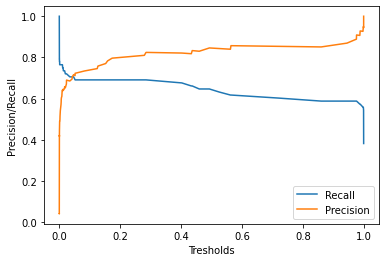

In [27]:
# Presicion / recall curve
precision,recall,tresholds = precision_recall_curve(target_val,predicted)

plt.plot(tresholds,recall[:-1],label="Recall")
plt.plot(tresholds,precision[:-1],label="Precision")
plt.xlabel("Tresholds")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

In [28]:
df_val['fraudulent'].value_counts(), sum(predicted >= threshold), sum(predicted < threshold)

(0    1720
 1      68
 Name: fraudulent, dtype: int64, array([46]), array([1742]))